In [1]:
import pickle as pkl
import cv2
import ipywidgets as widgets
from IPython.display import display
import os
import re
from collections import defaultdict
from pprint import pprint
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
video_id_07BSH = "07BSH.mp4"
video_id_07QNG = "07QNG.mp4"
video_id_015XE = "015XE.mp4"

In [3]:
def load_video_sgg_triplets(video_id: str):
    with open(f"/home/pali/repos/unbiasedSGG/output/predcls/{video_id}/no_constraint.pkl", "rb") as f:
        return pkl.load(f)

def load_gt_classes():
    object_classes = []
    with open('/home/pali/datasets/charades/dataset/ag/annotations/object_classes.txt', 'r') as file:
        for line in file:
            object_classes.append(line.strip()) 
            
    relationship_classes = []
    with open('/home/pali/datasets/charades/dataset/ag/annotations/relationship_classes.txt', 'r') as file:
        for line in file:
            relationship_classes.append(line.strip())

    return object_classes, relationship_classes

def load_video_frames(video_id: str):
    # Path to the directory containing the frames
    frames_dir = f'/home/pali/datasets/charades/dataset/ag/frames/{video_id}/'

    # Load and sort the frames
    frame_files = os.listdir(frames_dir)
    frame_files = sorted(frame_files, key=lambda x: int(re.search(r'\d+', x).group()))

    frames = []
    for frame_file in frame_files:
        frame_path = os.path.join(frames_dir, frame_file)
        frame = cv2.imread(frame_path)
        if frame is not None:
            frames.append(frame)

    print(f"Total frames: {len(frames)}")
    return frames


In [4]:
no_constraint_output_07BSH = load_video_sgg_triplets(video_id_07BSH)
no_constraint_output_07QNG = load_video_sgg_triplets(video_id_07QNG)
no_constraint_output_015XE = load_video_sgg_triplets(video_id_015XE)

In [5]:
object_classes, relationship_classes = load_gt_classes()

In [6]:
frames_video_07BSH = load_video_frames(video_id_07BSH)
frames_video_07QNG = load_video_frames(video_id_07QNG)
frames_video_015XE = load_video_frames(video_id_015XE)

Total frames: 15
Total frames: 68
Total frames: 15


*triplet_scores*: contains the confidence scores for each part of the triplet: [object 1 score, object 2 score, relationship score].

*triplet_labels* contains the labels for the triplets, where each triplet is [object 1 label, object 2 label, relationship label].

*triplet_boxes* provides the bounding boxes for the objects in each triplet. Each entry contains eight numbers, representing the bounding boxes for object 1 and object 2, respectively: [x1, y1, x2, y2, x3, y3, x4, y4], where (x1, y1, x2, y2) are the coordinates for object 1's bounding box and (x3, y3, x4, y4) for object 2's.

In [7]:
# This is a placeholder function. Replace it with your actual label mappings.
def get_label_name(label_id):
    # Placeholder: Map label ID to a string. You should replace this with your actual mapping.
    return object_classes[label_id-1]

def get_relationship_name(relationship_id):
    # Placeholder: Map relationship ID to a string. You should replace this with your actual mapping.
    return relationship_classes[relationship_id-1]

def plot_scene_graph(video):
    # semi_con_example = semi_con["00T1E.mp4/000297.png"]
    scene_graph_data = defaultdict(list)
    for k, semi_con_example in video.items():
        # Initialize an empty graph
        G = nx.DiGraph()

        # Iterate over the triplets to add nodes and edges
        for labels, boxes, scores in zip(semi_con_example['triplet_labels'], semi_con_example['triplet_boxes'], semi_con_example["triplet_scores"]):
            if scores[2] < 0.92: continue
            obj1_label, relationship_label, obj2_label = labels
            obj1_name = get_label_name(obj1_label)
            obj2_name = get_label_name(obj2_label)
            relationship_name = get_relationship_name(relationship_label)

            # Add nodes for the objects if they're not already in the graph
            if obj1_name not in G:
                G.add_node(obj1_name, box=boxes[:4])
            if obj2_name not in G:
                G.add_node(obj2_name, box=boxes[4:])

            # Add an edge for the relationship
            G.add_edge(obj1_name, obj2_name, relationship=relationship_name)

            print(f'{obj1_name} -- {relationship_name} --> {obj2_name}')
            scene_graph_data[k].append({
                'obj_1': obj1_name,
                'obj_2': obj2_name,
                'relationship': relationship_name
            })


        # Draw the graph
        pos = nx.spring_layout(G)  # This is one way to layout graphs; you might need to customize this.
        nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=700, edge_color='k', linewidths=1, font_size=10, arrows=True, arrowstyle='-|>')
        plt.title('Scene Graph Visualization')
        plt.show()
    return scene_graph_data

person -- haveitontheback --> phonecamera
phonecamera -- unsure --> person
phonecamera -- beneath --> person


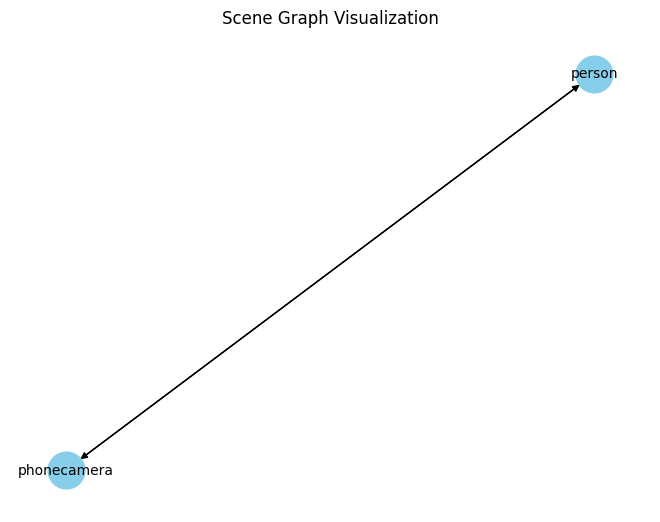

person -- haveitontheback --> phonecamera
phonecamera -- unsure --> person
phonecamera -- beneath --> person


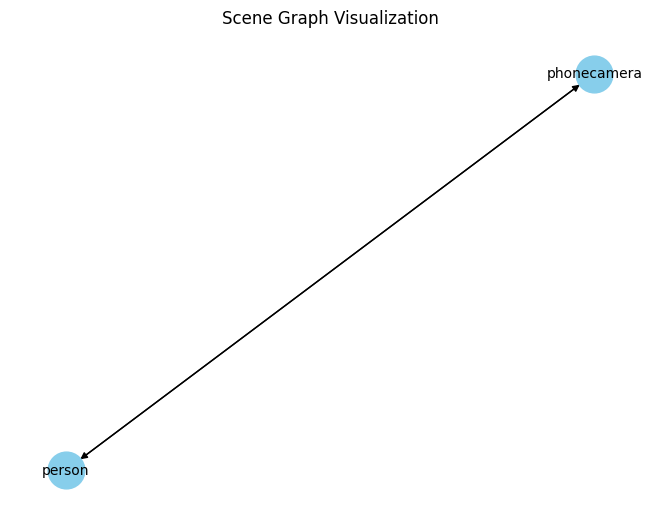

person -- haveitontheback --> phonecamera
phonecamera -- unsure --> person


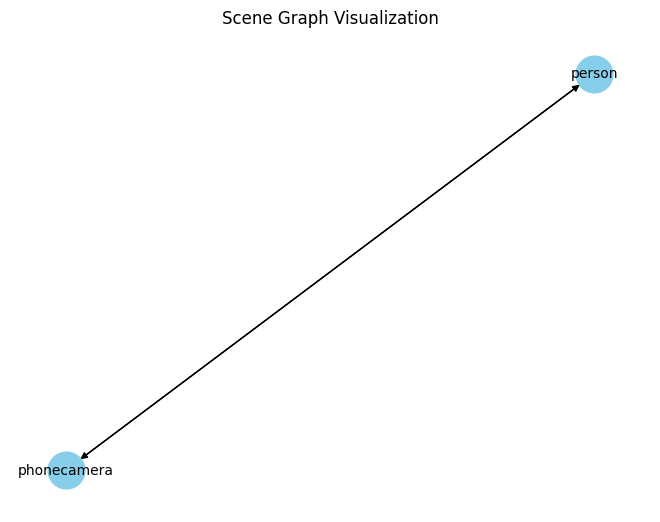

In [8]:
scene_graph_015XE = plot_scene_graph(no_constraint_output_015XE)

person -- writingon --> book
person -- writingon --> papernotebook
bed -- above --> person
person -- lookingat --> bed
person -- otherrelationship --> bed
book -- beneath --> person
papernotebook -- beneath --> person
bed -- infrontof --> person
person -- standingon --> book


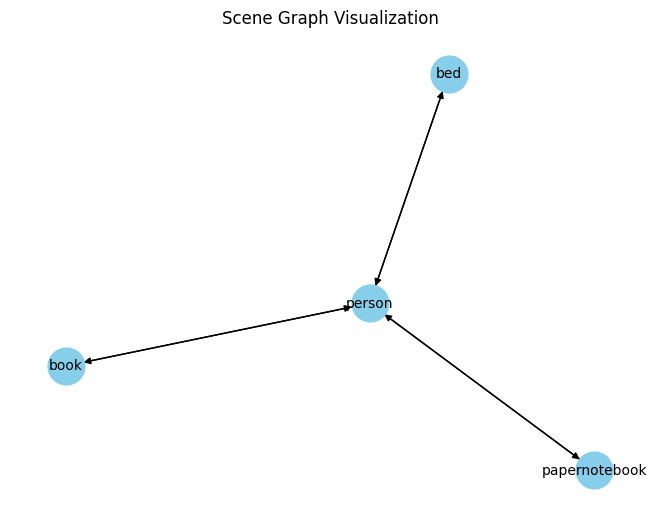

person -- writingon --> book
person -- writingon --> papernotebook
bed -- above --> person
person -- otherrelationship --> bed
person -- lookingat --> bed
book -- beneath --> person
papernotebook -- beneath --> person
bed -- infrontof --> person
person -- standingon --> book


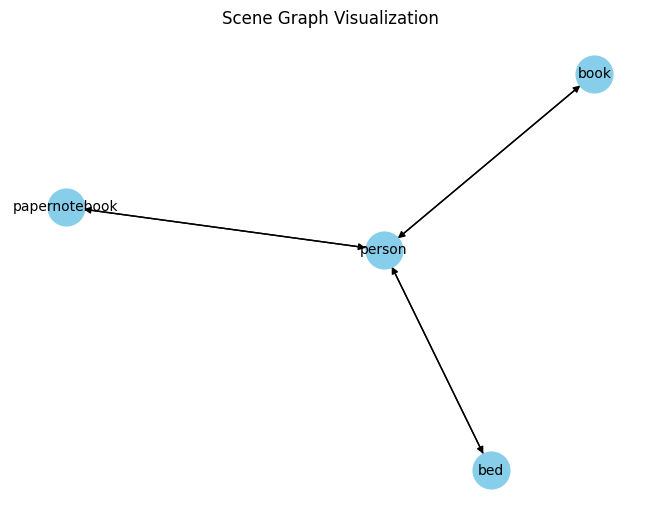

person -- writingon --> book
person -- writingon --> papernotebook
book -- beneath --> person
papernotebook -- beneath --> person
person -- otherrelationship --> bed
bed -- above --> person
person -- lookingat --> bed
person -- standingon --> book


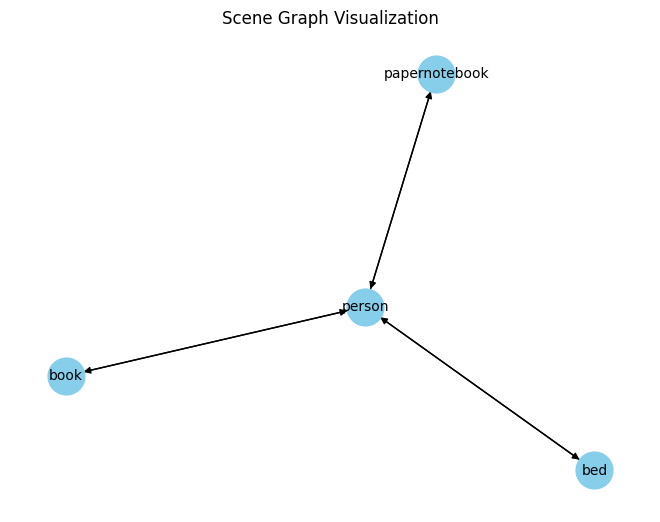

person -- writingon --> book
person -- writingon --> papernotebook
book -- beneath --> person
person -- lookingat --> bed
papernotebook -- beneath --> person
bed -- above --> person
person -- otherrelationship --> bed
person -- standingon --> book


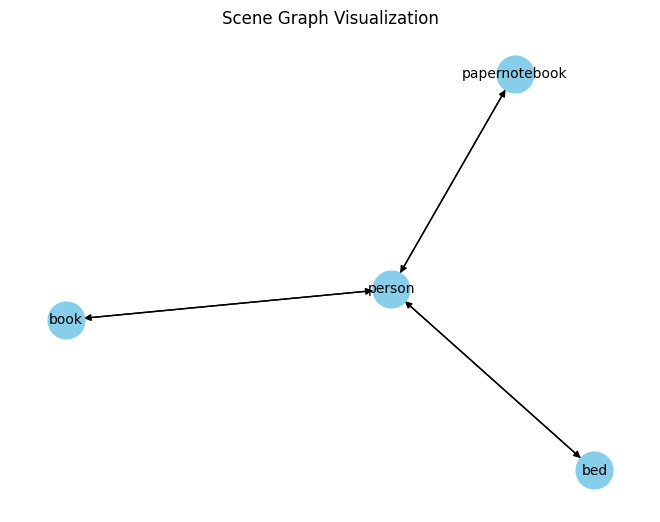

person -- writingon --> book
person -- writingon --> papernotebook
book -- beneath --> person
person -- otherrelationship --> bed
bed -- above --> person
person -- lookingat --> bed
papernotebook -- beneath --> person
person -- standingon --> book
bed -- infrontof --> person


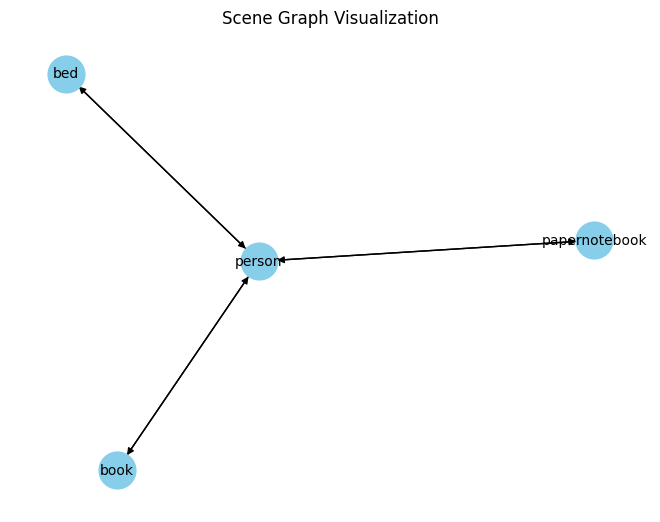

person -- writingon --> papernotebook
person -- writingon --> book
book -- beneath --> person
papernotebook -- beneath --> person
person -- lookingat --> bed
person -- otherrelationship --> bed
bed -- above --> person
person -- standingon --> book
person -- standingon --> papernotebook


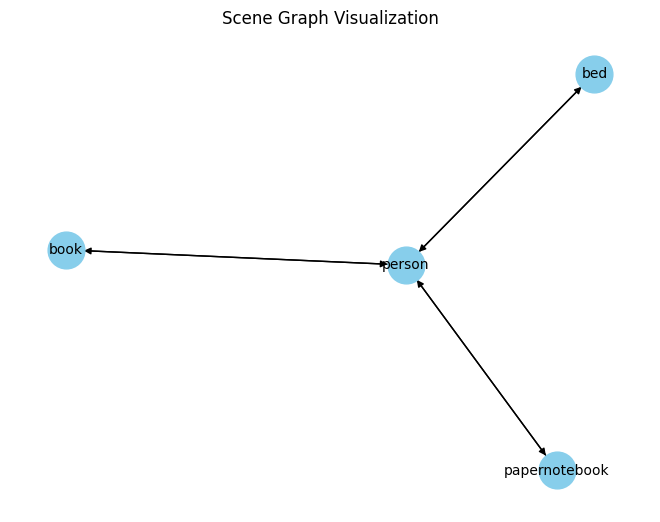

person -- writingon --> papernotebook
person -- writingon --> book
book -- beneath --> person
papernotebook -- beneath --> person
person -- lookingat --> bed
person -- otherrelationship --> bed
person -- standingon --> book
bed -- above --> person
person -- standingon --> papernotebook


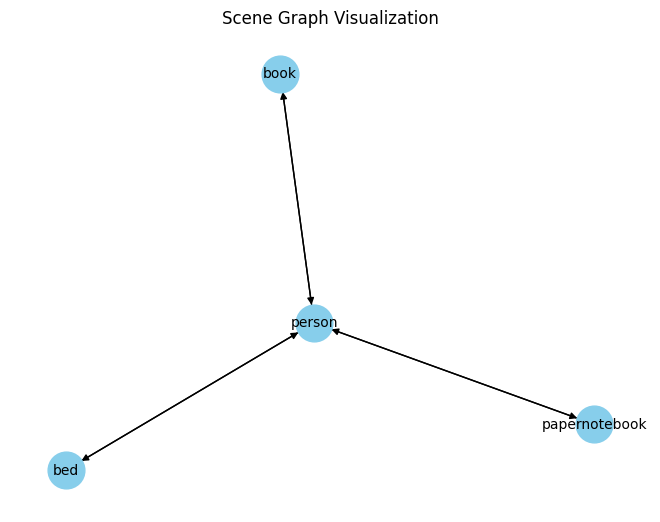

person -- writingon --> book
person -- writingon --> papernotebook
book -- beneath --> person
person -- otherrelationship --> bed
bed -- above --> person
person -- lookingat --> bed
papernotebook -- beneath --> person
person -- standingon --> book
bed -- infrontof --> person


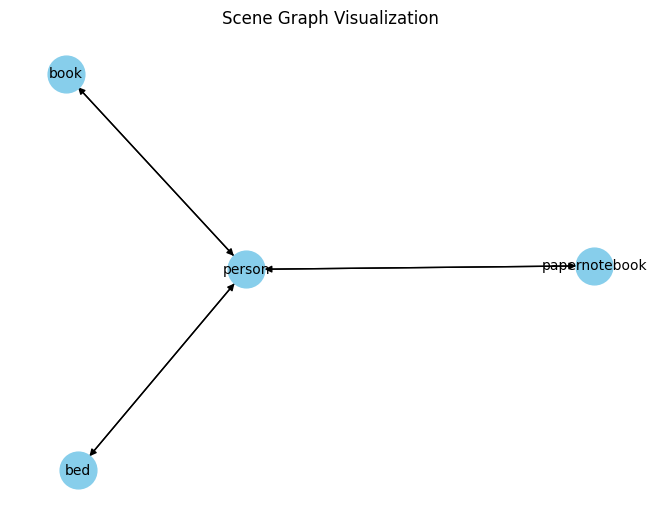

person -- writingon --> book
person -- writingon --> papernotebook
book -- beneath --> person
person -- lookingat --> bed
person -- otherrelationship --> bed
papernotebook -- beneath --> person
bed -- above --> person
person -- standingon --> book
person -- standingon --> papernotebook


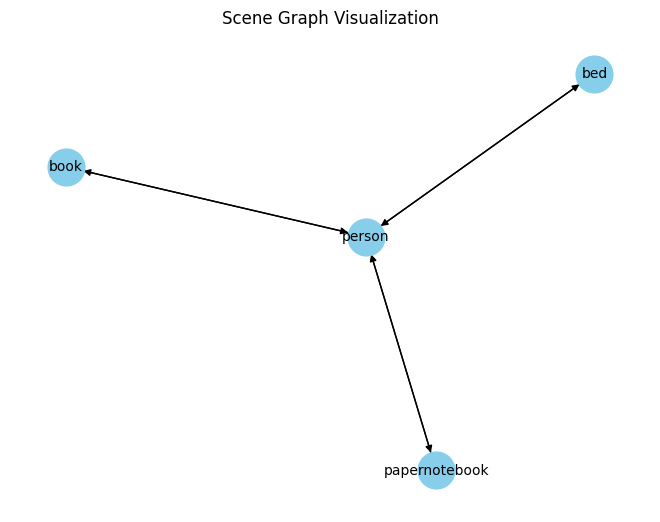

person -- writingon --> book
person -- writingon --> papernotebook
person -- lookingat --> bed
book -- beneath --> person
bed -- above --> person
person -- otherrelationship --> bed
papernotebook -- beneath --> person
person -- standingon --> book


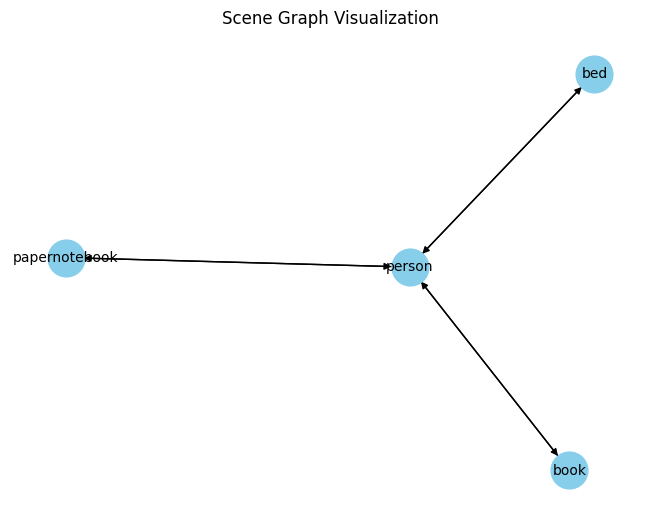

person -- writingon --> book
person -- writingon --> papernotebook
person -- otherrelationship --> bed
person -- lookingat --> bed
bed -- above --> person
book -- beneath --> person
papernotebook -- beneath --> person
person -- standingon --> book


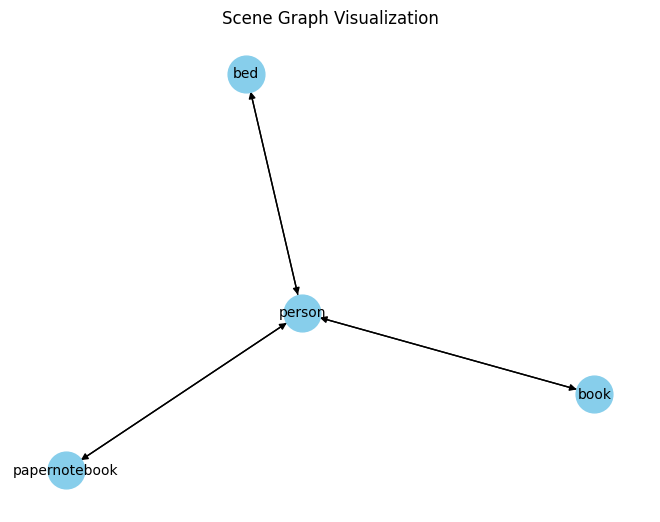

person -- lookingat --> bed
person -- writingon --> book
person -- writingon --> papernotebook
bed -- above --> person
book -- beneath --> person
person -- otherrelationship --> bed
papernotebook -- beneath --> person
person -- standingon --> book
bed -- infrontof --> person


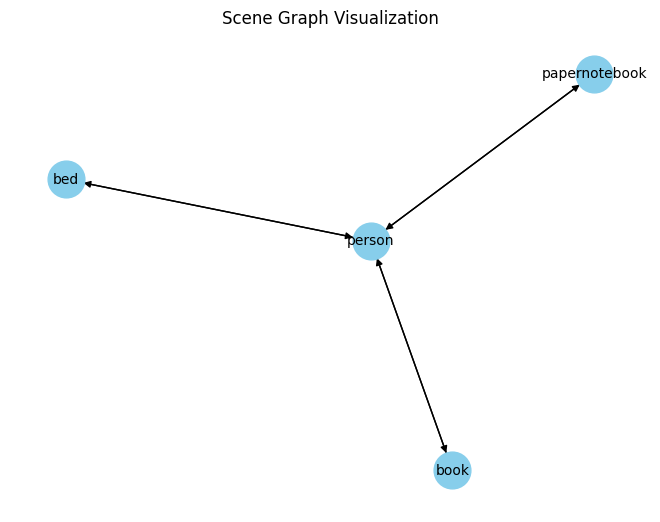

person -- writingon --> papernotebook
person -- writingon --> book
book -- beneath --> person
person -- otherrelationship --> bed
person -- lookingat --> bed
bed -- above --> person
papernotebook -- beneath --> person
person -- standingon --> book


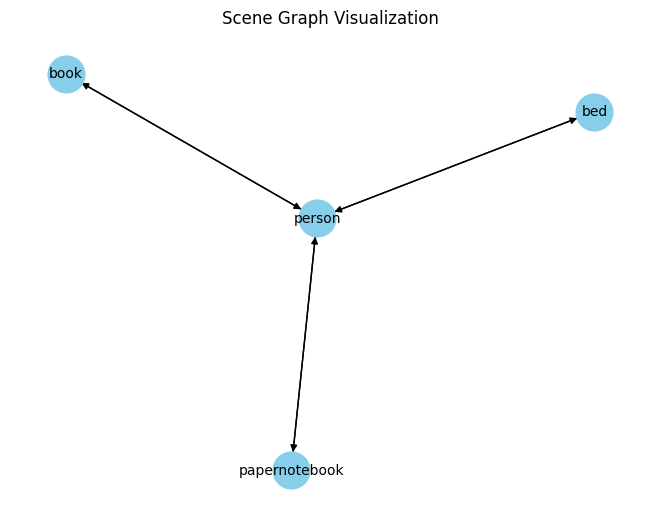

person -- writingon --> papernotebook
person -- otherrelationship --> bed
papernotebook -- beneath --> person
person -- lookingat --> bed
bed -- above --> person


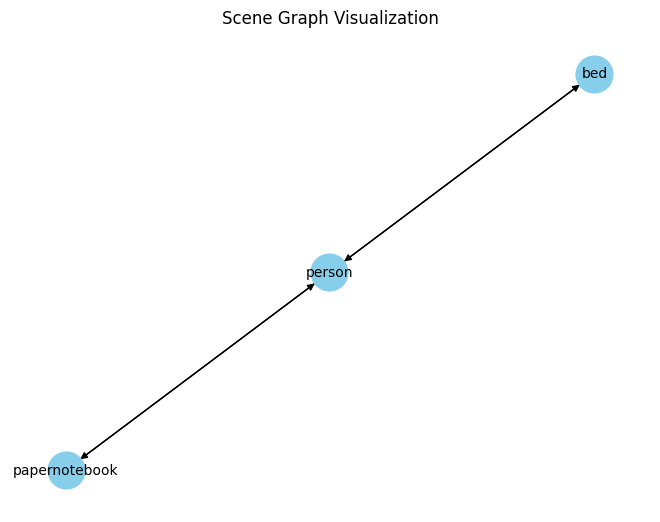

person -- writingon --> papernotebook
person -- otherrelationship --> bed
bed -- above --> person
papernotebook -- beneath --> person
person -- lookingat --> bed


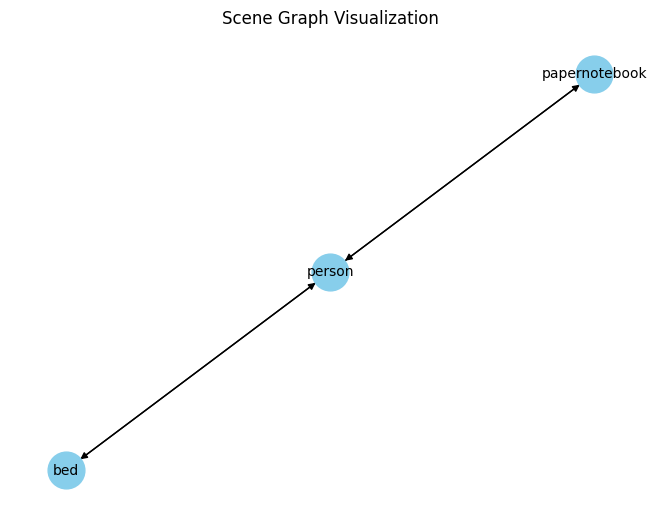

person -- writingon --> papernotebook
person -- otherrelationship --> bed
papernotebook -- beneath --> person
person -- lookingat --> bed
bed -- above --> person


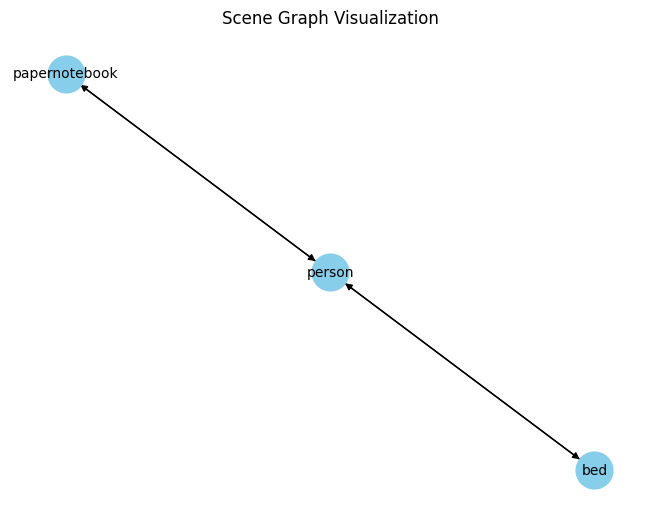

person -- writingon --> papernotebook
person -- lookingat --> bed
papernotebook -- beneath --> person
person -- otherrelationship --> bed
bed -- above --> person


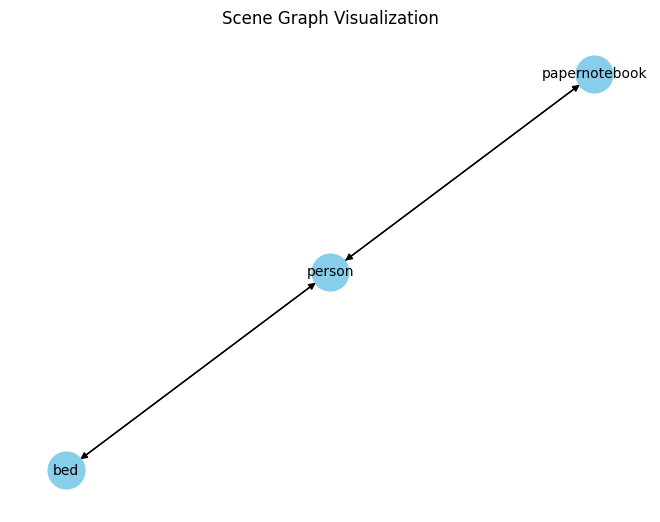

person -- writingon --> papernotebook
person -- lookingat --> bed
person -- otherrelationship --> bed
papernotebook -- beneath --> person
bed -- above --> person


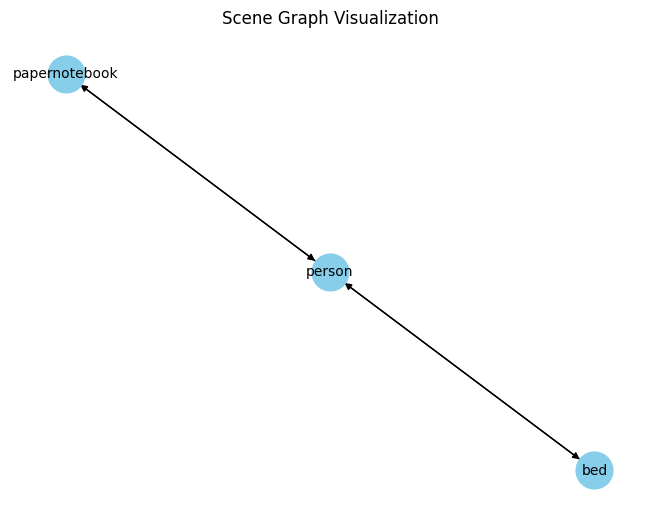

person -- writingon --> papernotebook
person -- lookingat --> bed
papernotebook -- beneath --> person
person -- otherrelationship --> bed
bed -- above --> person


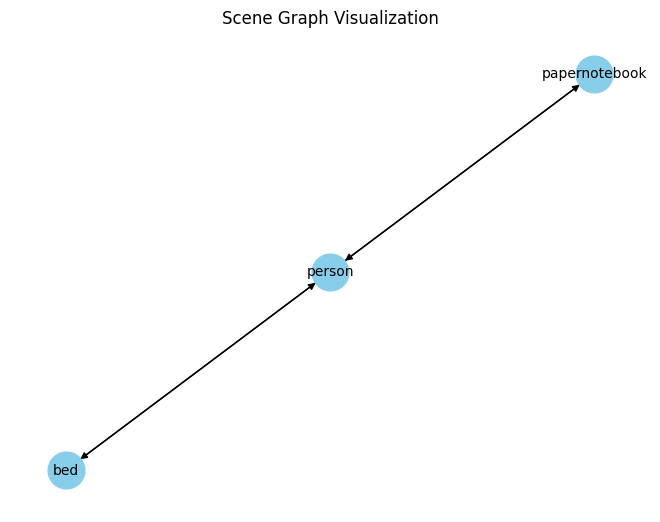

person -- writingon --> papernotebook
person -- otherrelationship --> bed
bed -- above --> person
person -- lookingat --> bed
papernotebook -- beneath --> person
bed -- infrontof --> person


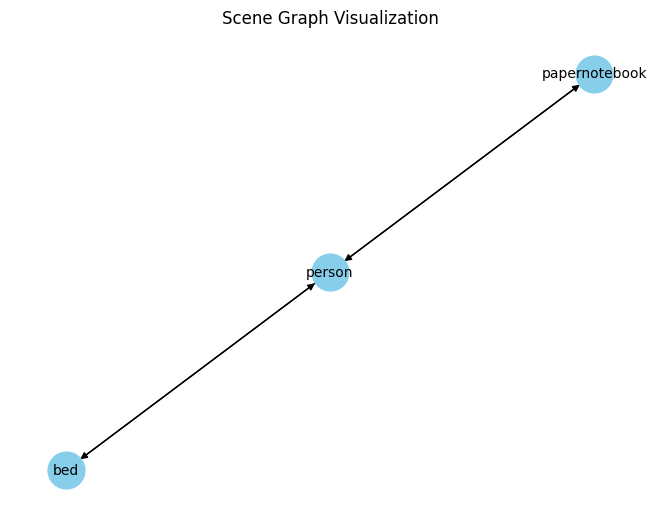

person -- writingon --> papernotebook
person -- lookingat --> bed
person -- otherrelationship --> bed
bed -- above --> person
papernotebook -- beneath --> person


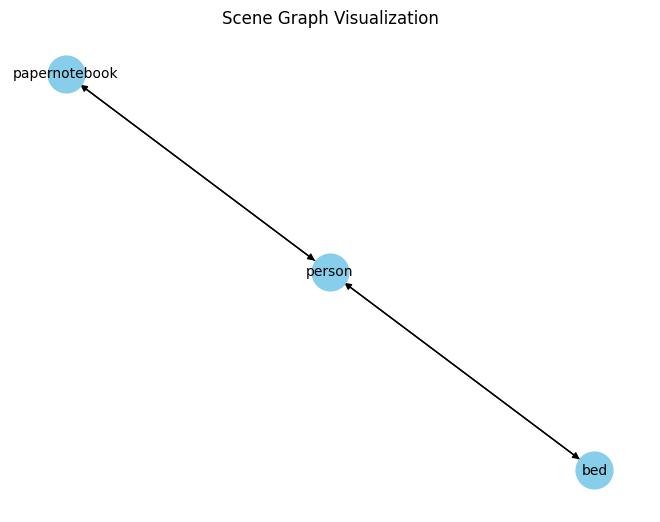

person -- writingon --> papernotebook
papernotebook -- beneath --> person
person -- lookingat --> bed
person -- otherrelationship --> bed
bed -- above --> person


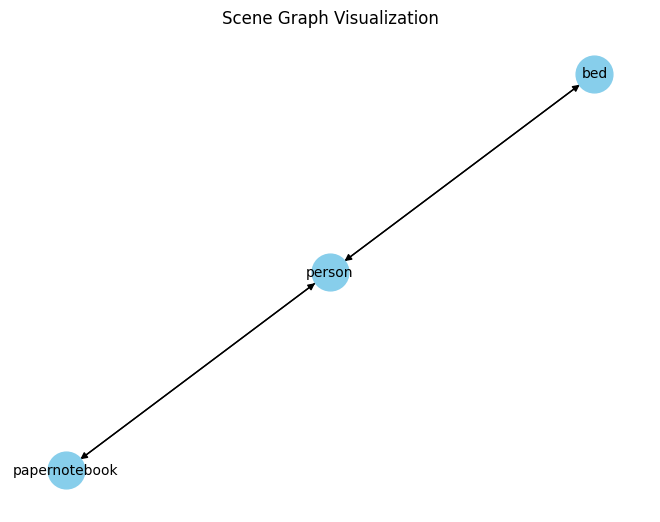

person -- writingon --> papernotebook
person -- lookingat --> bed
papernotebook -- beneath --> person
person -- otherrelationship --> bed
bed -- above --> person


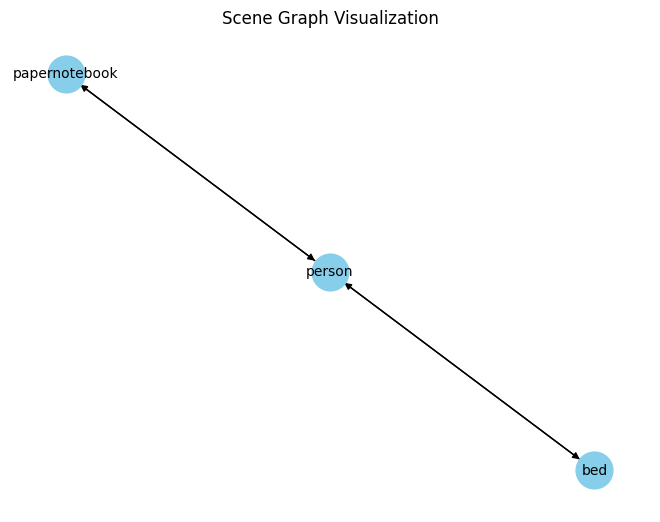

person -- writingon --> papernotebook
papernotebook -- beneath --> person
person -- lookingat --> bed
person -- otherrelationship --> bed
bed -- above --> person
person -- standingon --> papernotebook


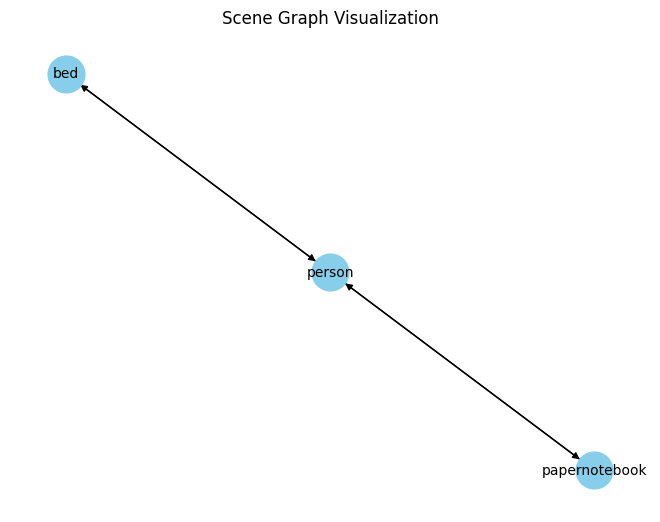

person -- writingon --> papernotebook
person -- otherrelationship --> bed
person -- lookingat --> bed
bed -- above --> person
papernotebook -- beneath --> person


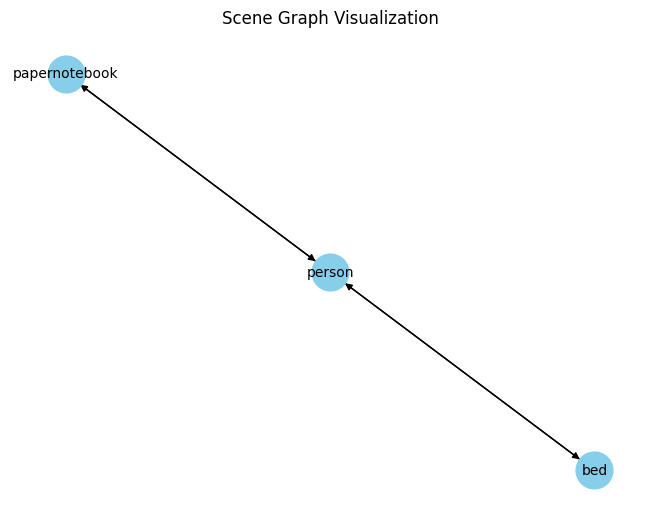

person -- writingon --> papernotebook
person -- lookingat --> bed
papernotebook -- beneath --> person
bed -- above --> person
person -- otherrelationship --> bed
person -- standingon --> papernotebook


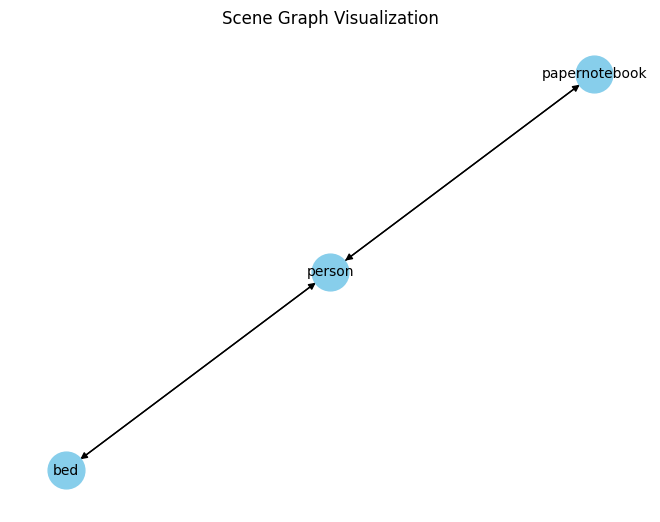

person -- writingon --> papernotebook
person -- lookingat --> bed
bed -- above --> person
person -- otherrelationship --> bed
papernotebook -- beneath --> person
person -- standingon --> papernotebook


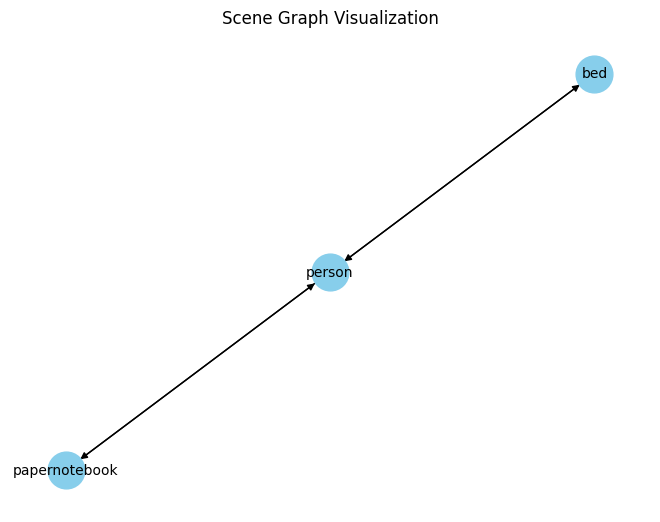

person -- writingon --> papernotebook
person -- otherrelationship --> bed
person -- lookingat --> bed
bed -- above --> person
papernotebook -- beneath --> person


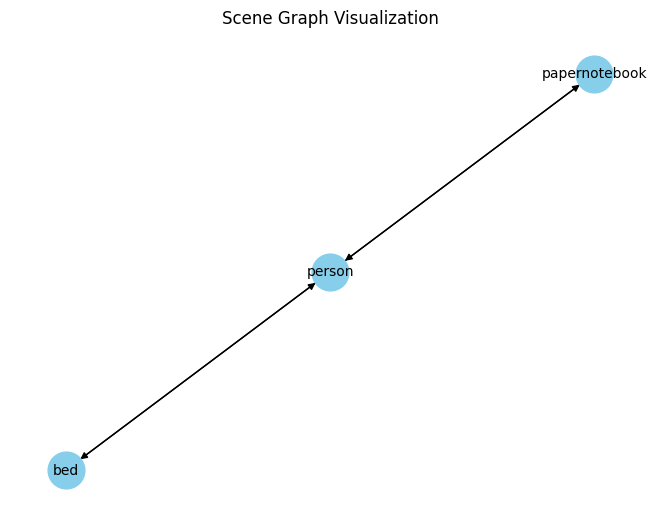

person -- writingon --> papernotebook
person -- lookingat --> bed
bed -- above --> person
papernotebook -- beneath --> person
person -- otherrelationship --> bed
person -- lyingon --> papernotebook


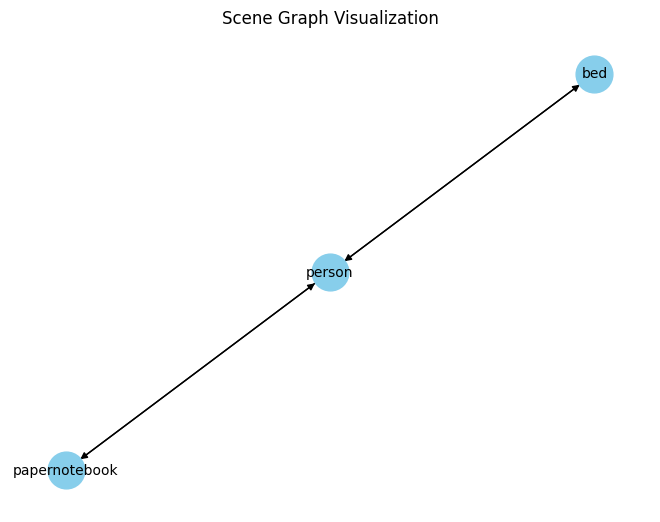

person -- lookingat --> bed
bed -- above --> person
person -- otherrelationship --> bed
papernotebook -- beneath --> person
person -- lyingon --> papernotebook
person -- writingon --> papernotebook


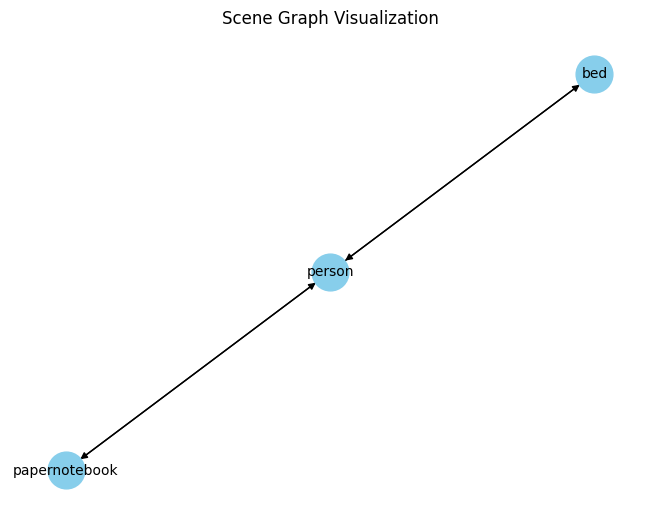

cupglassbottle -- beneath --> person


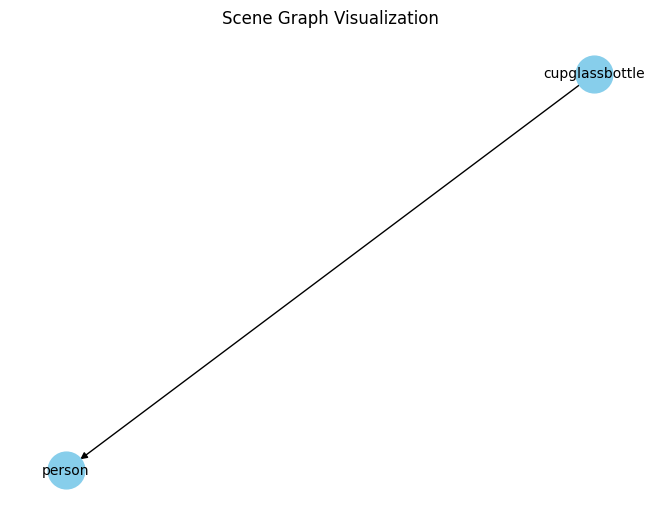

cupglassbottle -- beneath --> person
person -- lookingat --> cupglassbottle
person -- haveitontheback --> cupglassbottle


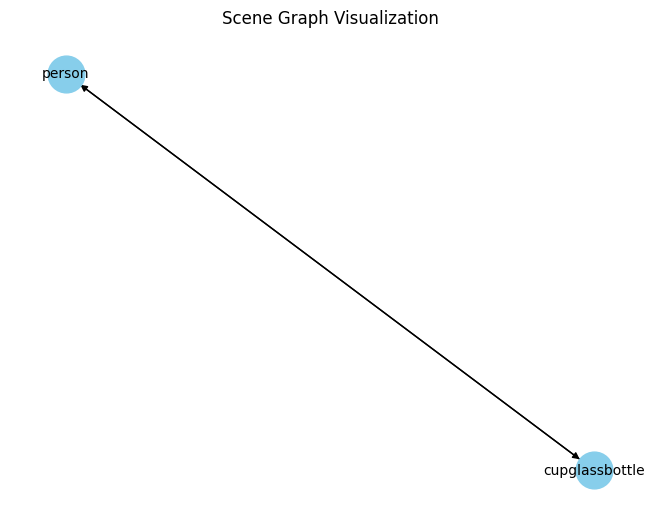

cupglassbottle -- beneath --> person
dish -- beneath --> person
person -- haveitontheback --> dish
person -- haveitontheback --> cupglassbottle
person -- writingon --> cupglassbottle
person -- writingon --> dish


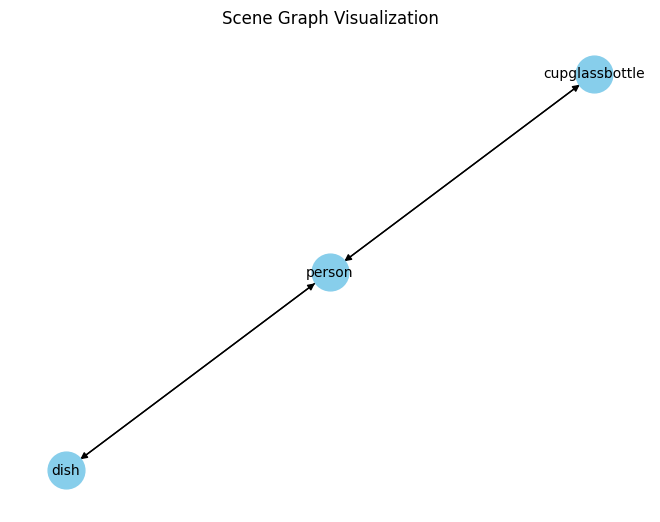

cupglassbottle -- beneath --> person
dish -- beneath --> person
person -- haveitontheback --> dish
person -- haveitontheback --> cupglassbottle


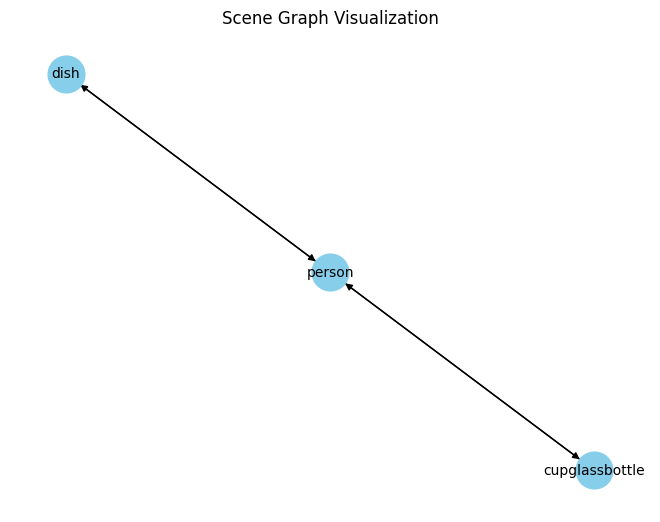

cupglassbottle -- beneath --> person
dish -- beneath --> person


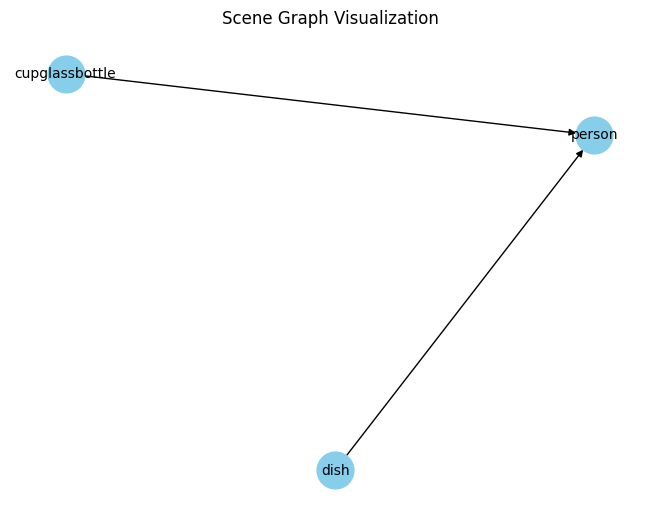

cupglassbottle -- beneath --> person
dish -- beneath --> person
person -- writingon --> cupglassbottle
person -- haveitontheback --> dish
person -- haveitontheback --> cupglassbottle


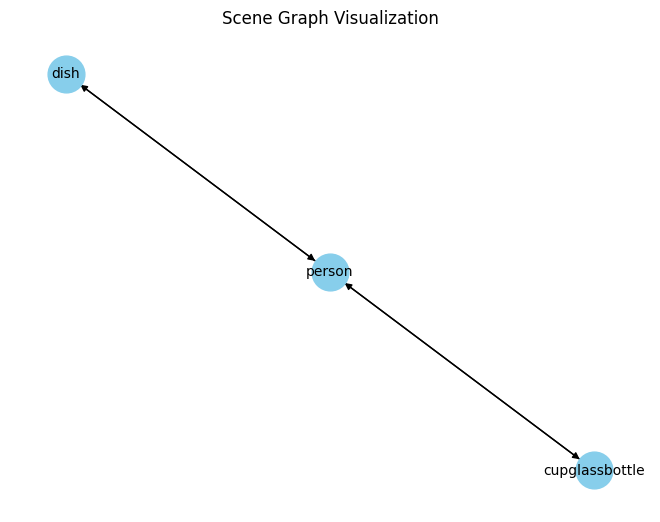

dish -- beneath --> person
cupglassbottle -- beneath --> person
person -- haveitontheback --> dish
person -- writingon --> dish


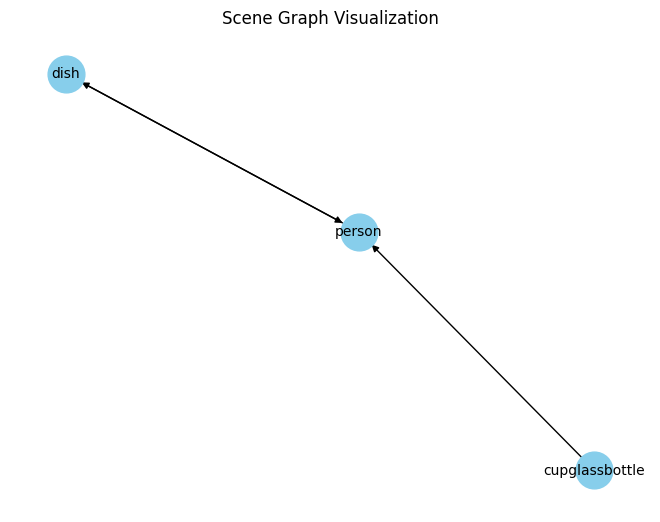

cupglassbottle -- beneath --> person
dish -- beneath --> person
person -- writingon --> dish
person -- writingon --> cupglassbottle
person -- haveitontheback --> dish
person -- haveitontheback --> cupglassbottle


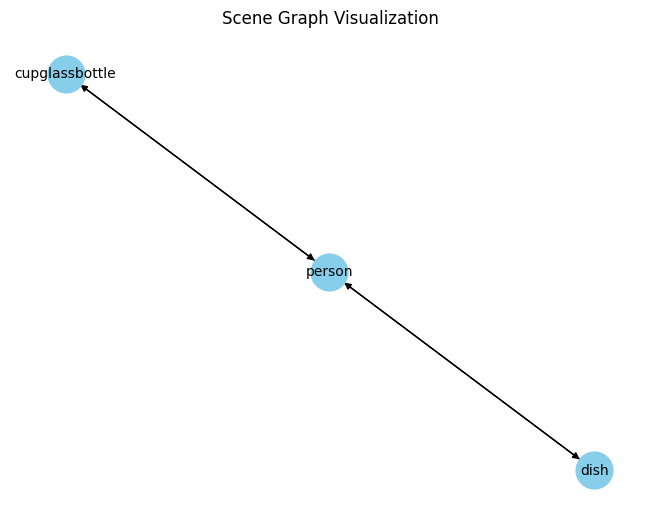

cupglassbottle -- beneath --> person
person -- lookingat --> cupglassbottle
dish -- beneath --> person
person -- lookingat --> dish
person -- haveitontheback --> dish
person -- haveitontheback --> cupglassbottle


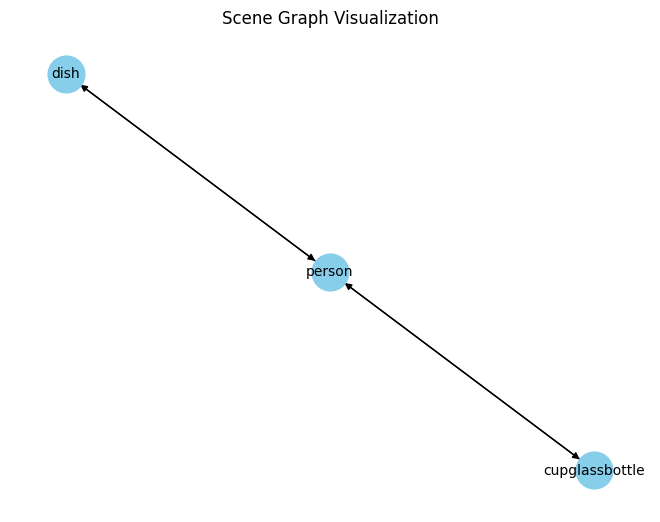

dish -- beneath --> person
cupglassbottle -- beneath --> person
person -- lookingat --> cupglassbottle
person -- lookingat --> dish
person -- haveitontheback --> dish


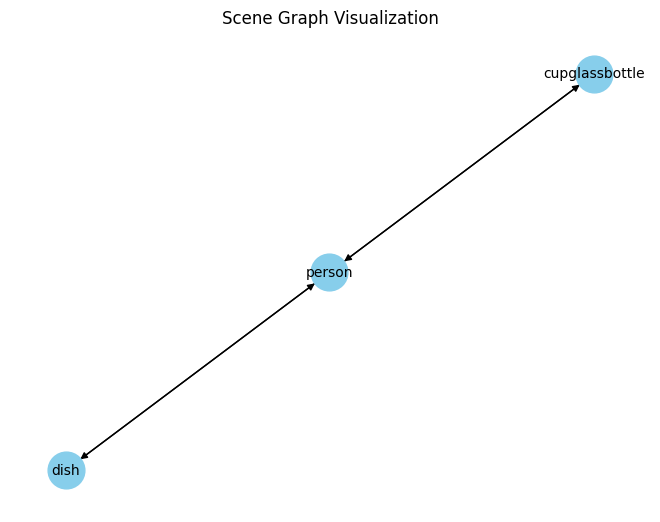

cupglassbottle -- beneath --> person
dish -- beneath --> person
person -- haveitontheback --> cupglassbottle
person -- haveitontheback --> dish


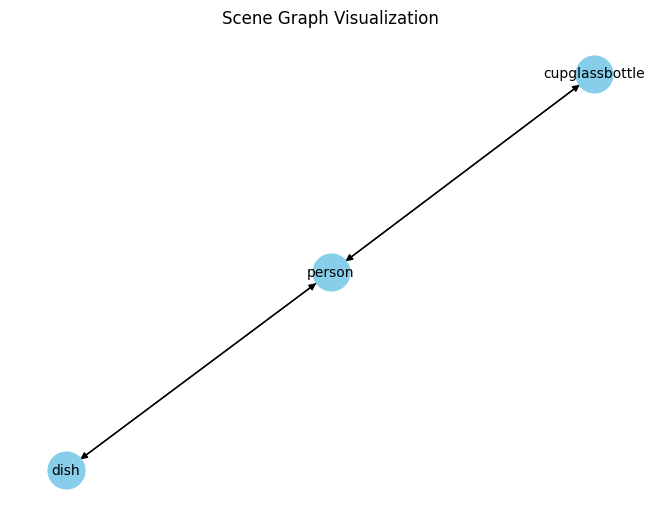

cupglassbottle -- beneath --> person
dish -- beneath --> person
person -- haveitontheback --> dish
person -- haveitontheback --> cupglassbottle
person -- writingon --> dish
person -- writingon --> cupglassbottle
person -- coveredby --> cupglassbottle


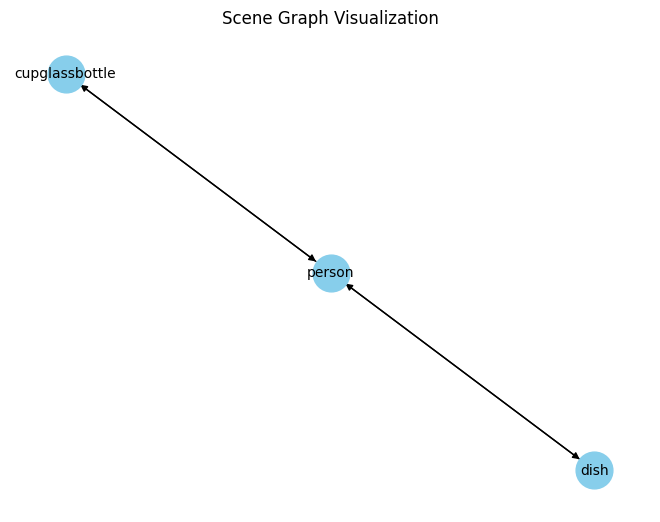

cupglassbottle -- beneath --> person
dish -- beneath --> person
person -- haveitontheback --> cupglassbottle
person -- haveitontheback --> dish
person -- coveredby --> cupglassbottle
person -- writingon --> dish
person -- writingon --> cupglassbottle


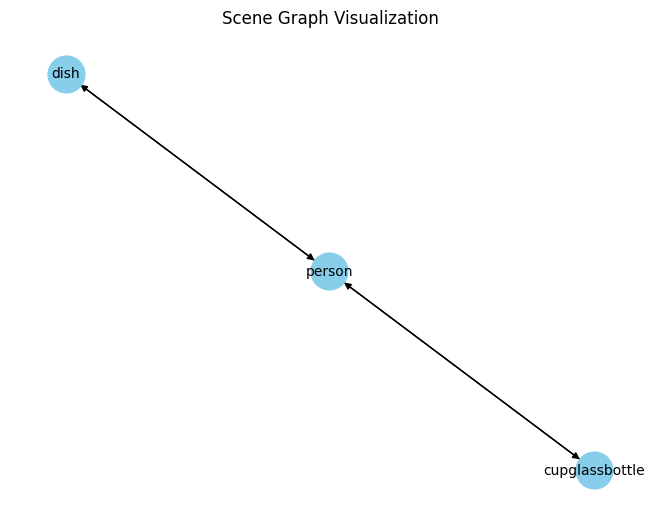

cupglassbottle -- beneath --> person
dish -- beneath --> person
person -- haveitontheback --> cupglassbottle
person -- haveitontheback --> dish
person -- coveredby --> cupglassbottle
person -- writingon --> cupglassbottle
person -- writingon --> dish
person -- drinkingfrom --> dish
person -- drinkingfrom --> cupglassbottle


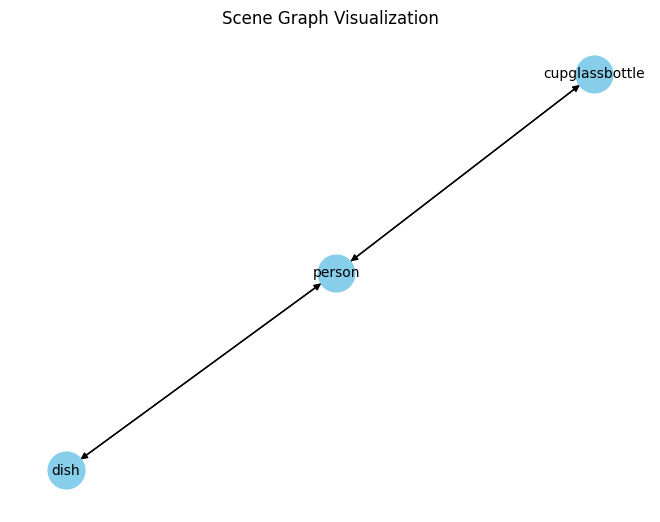

cupglassbottle -- beneath --> person
person -- haveitontheback --> cupglassbottle
person -- coveredby --> cupglassbottle
person -- writingon --> cupglassbottle
person -- drinkingfrom --> cupglassbottle


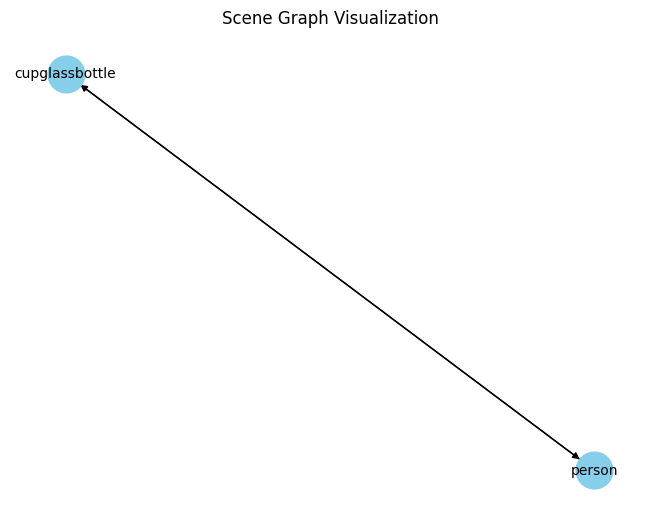

cupglassbottle -- beneath --> person
person -- coveredby --> cupglassbottle
person -- haveitontheback --> cupglassbottle
person -- writingon --> cupglassbottle
person -- drinkingfrom --> cupglassbottle


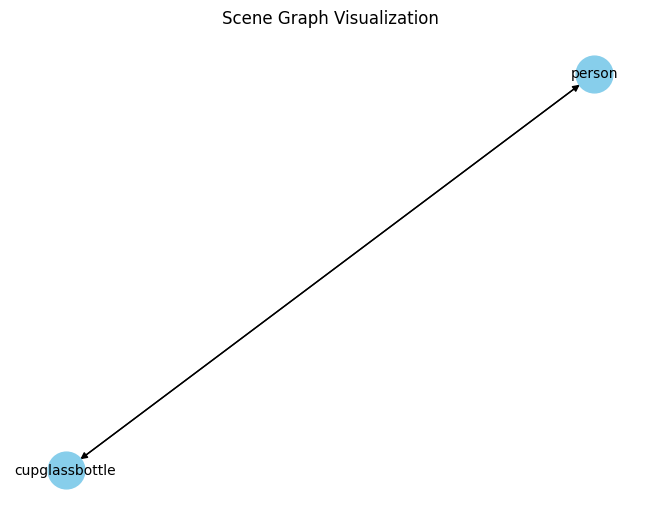

cupglassbottle -- beneath --> person
person -- coveredby --> cupglassbottle
person -- haveitontheback --> cupglassbottle
person -- writingon --> cupglassbottle


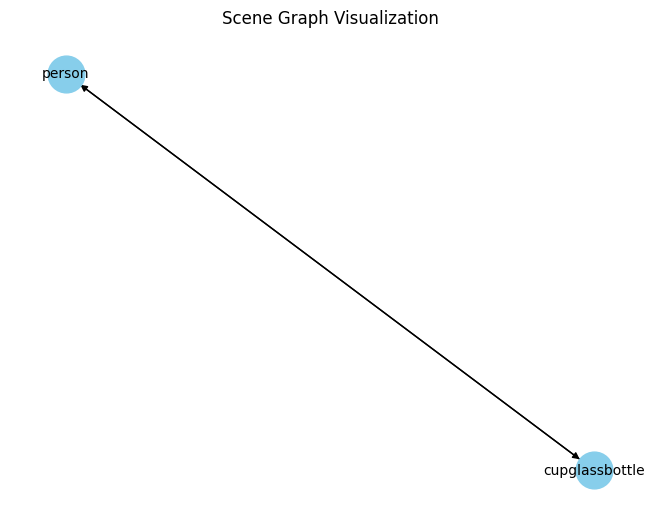

person -- writingon --> book
book -- beneath --> person
person -- standingon --> book


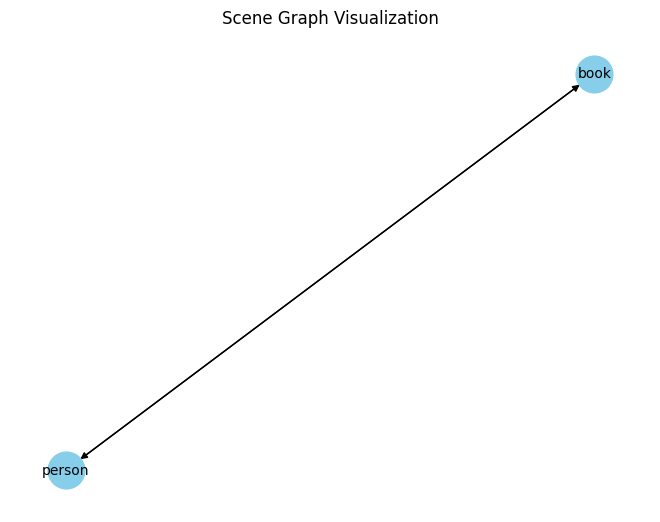

person -- writingon --> book
book -- beneath --> person
person -- standingon --> book


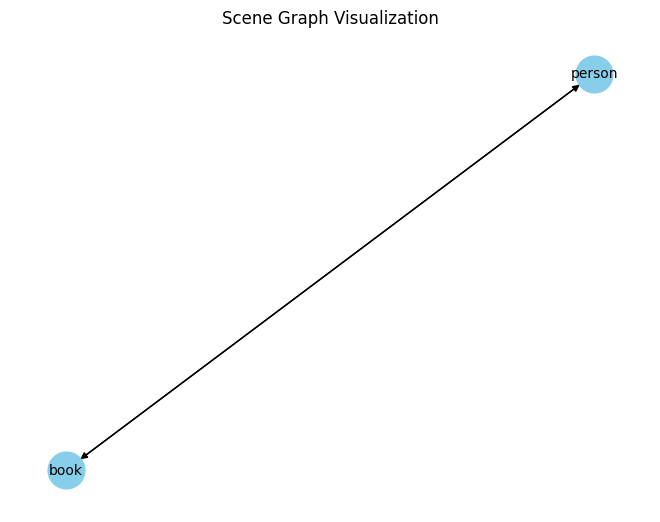

person -- writingon --> book
book -- beneath --> person
person -- haveitontheback --> book


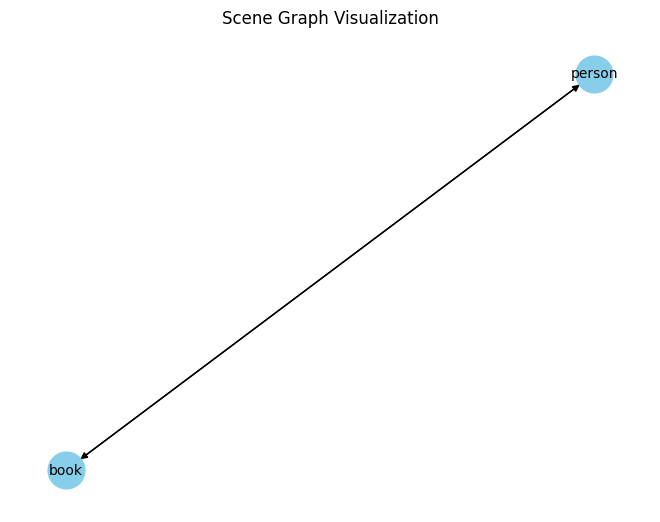

person -- writingon --> book
book -- beneath --> person
person -- haveitontheback --> book
person -- standingon --> book


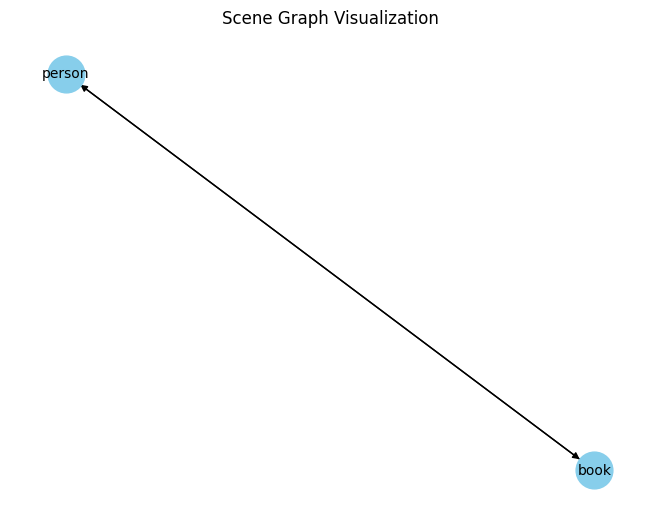

person -- writingon --> book
book -- beneath --> person
person -- standingon --> book
person -- haveitontheback --> book


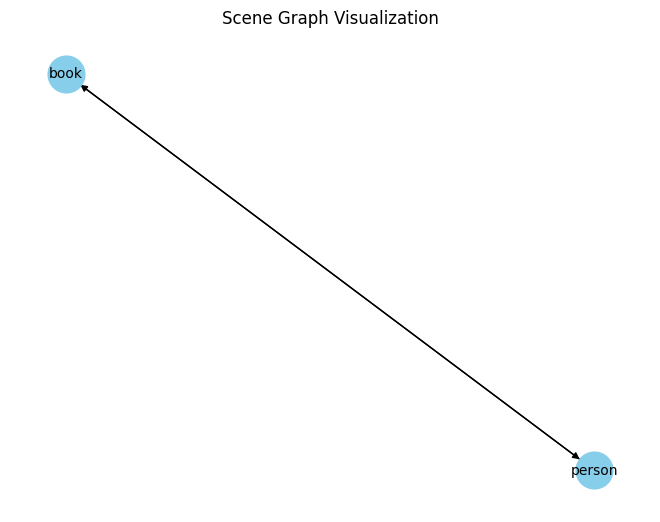

person -- writingon --> book
book -- beneath --> person
person -- standingon --> book


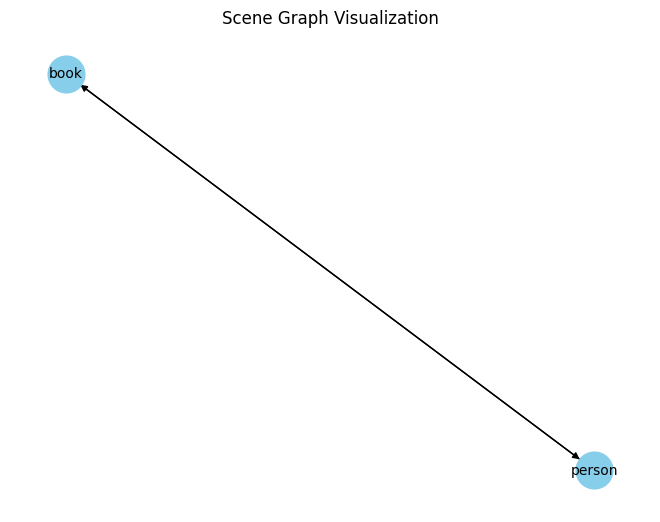

person -- writingon --> book
book -- beneath --> person
person -- standingon --> book


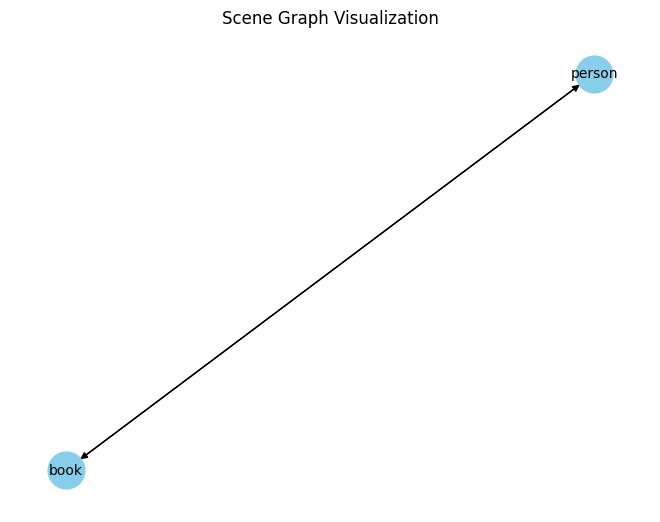

In [9]:
scene_graph_07QNG = plot_scene_graph(no_constraint_output_07QNG)

floor -- above --> person
vacuum -- beneath --> person
person -- haveitontheback --> vacuum
person -- sittingon --> floor
person -- writingon --> vacuum
person -- writingon --> floor


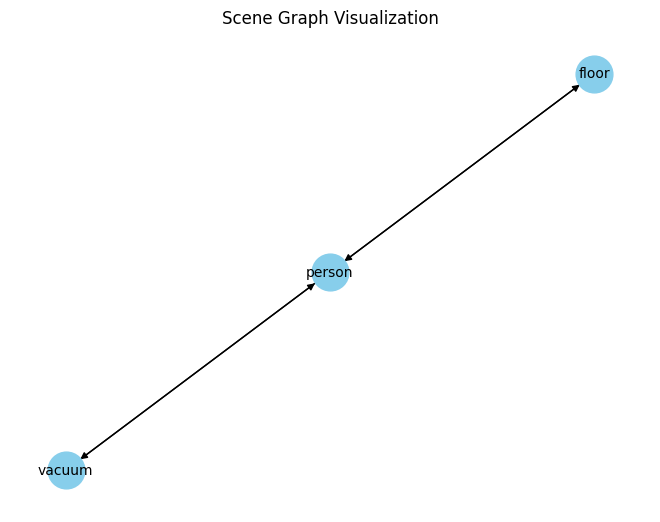

floor -- above --> person
vacuum -- beneath --> person
person -- haveitontheback --> vacuum
person -- sittingon --> floor
person -- writingon --> vacuum


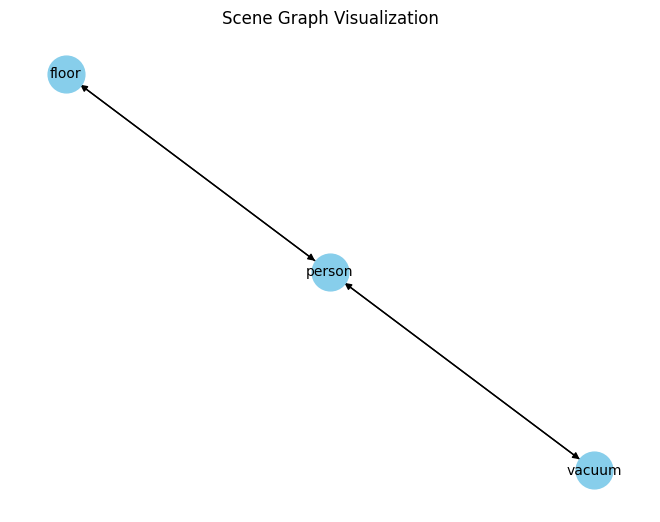

floor -- above --> person
person -- sittingon --> floor
person -- writingon --> floor
person -- haveitontheback --> vacuum
vacuum -- beneath --> person


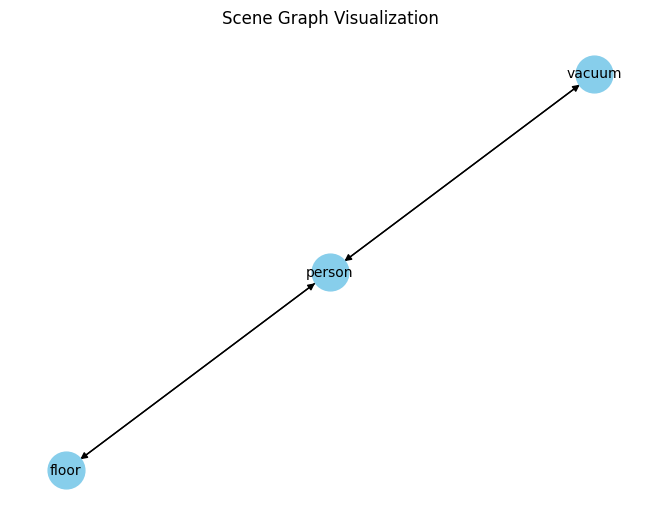

person -- haveitontheback --> vacuum
vacuum -- beneath --> person
person -- writingon --> vacuum


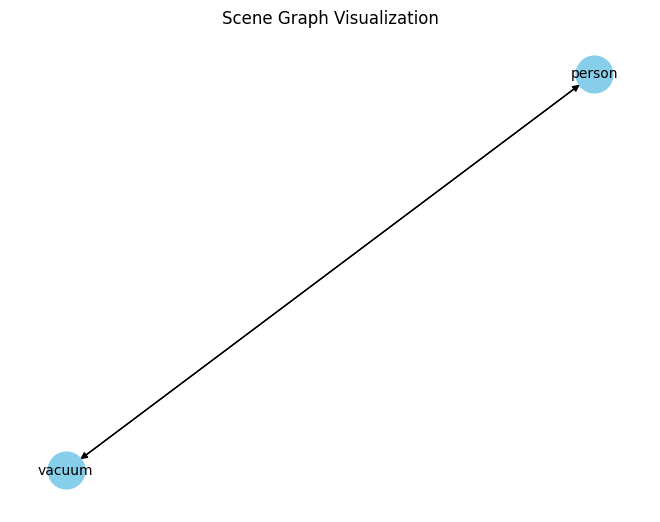

vacuum -- beneath --> person
person -- haveitontheback --> vacuum


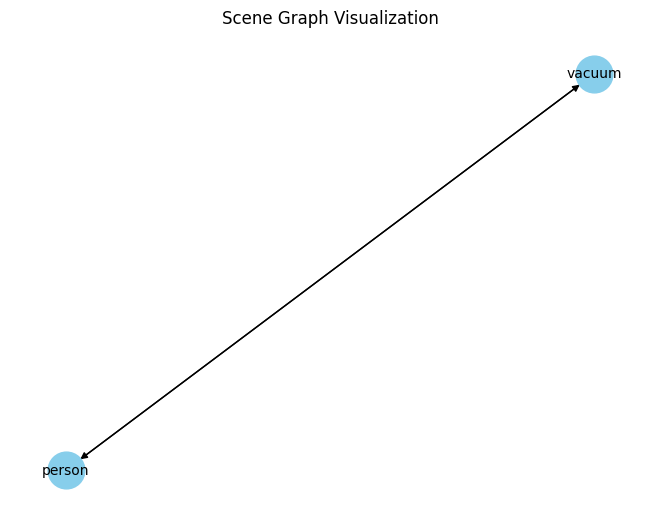

floor -- above --> person
person -- sittingon --> floor
vacuum -- beneath --> person
person -- haveitontheback --> vacuum
person -- writingon --> vacuum
person -- notlookingat --> floor


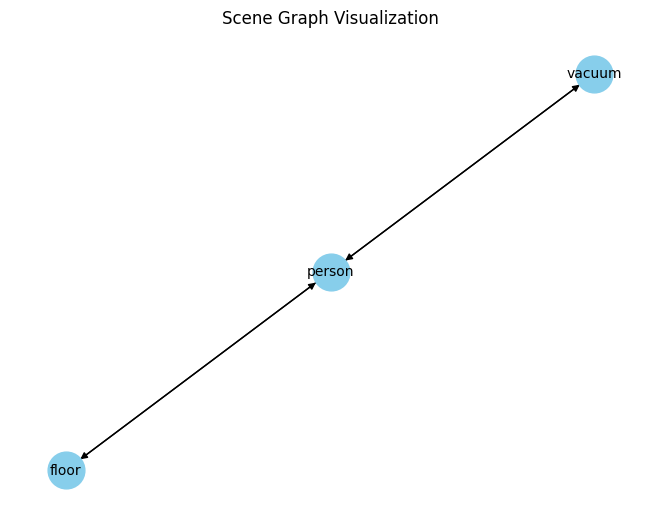

person -- haveitontheback --> vacuum
vacuum -- beneath --> person
person -- writingon --> vacuum


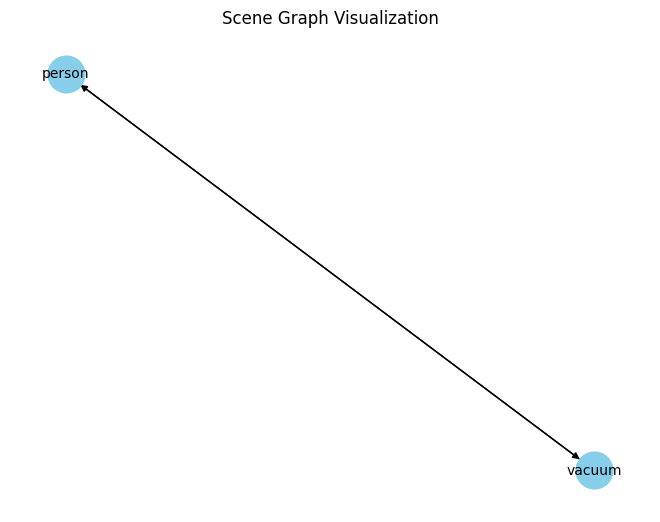

floor -- above --> person
person -- haveitontheback --> vacuum
person -- sittingon --> floor
vacuum -- beneath --> person
person -- writingon --> vacuum


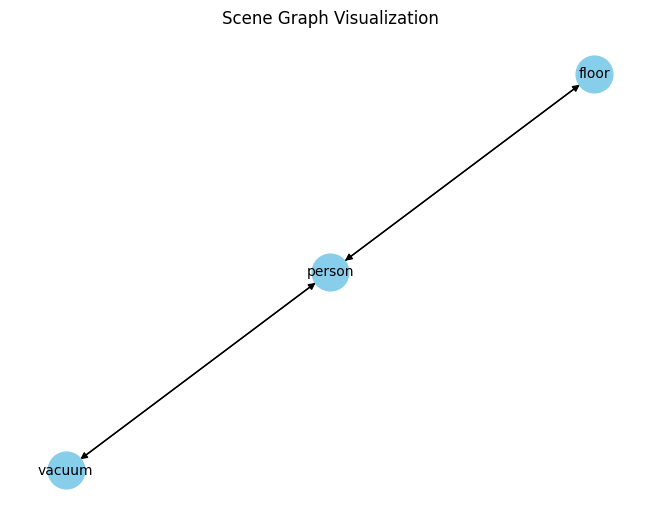

person -- writingon --> vacuum
floor -- above --> person
person -- sittingon --> floor
vacuum -- beneath --> person
person -- lyingon --> bag
person -- lookingat --> bag
bag -- beneath --> person
person -- writingon --> floor


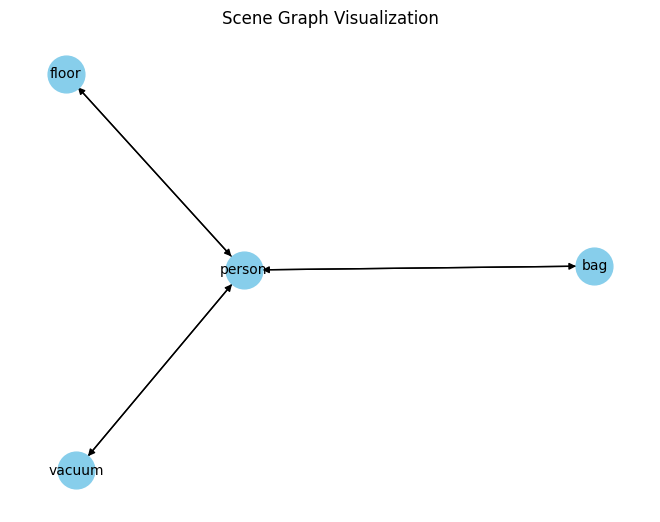

floor -- above --> person
person -- writingon --> vacuum
person -- lyingon --> bag
vacuum -- beneath --> person
person -- sittingon --> floor
person -- lookingat --> bag
bag -- beneath --> person
person -- writingon --> floor


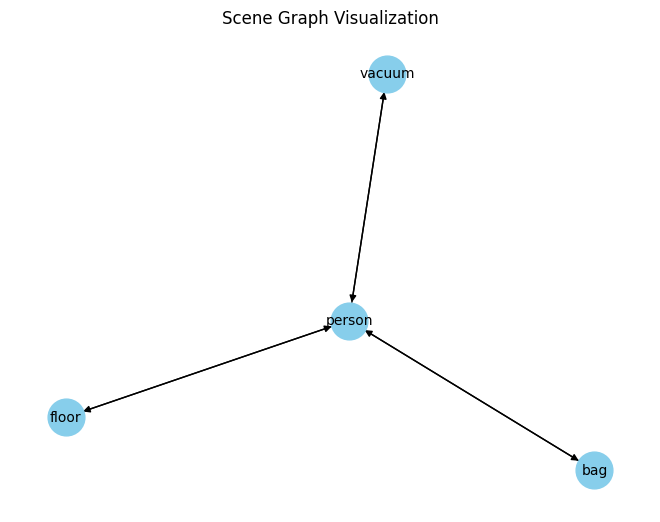

person -- writingon --> bag
bag -- beneath --> person
person -- haveitontheback --> bag


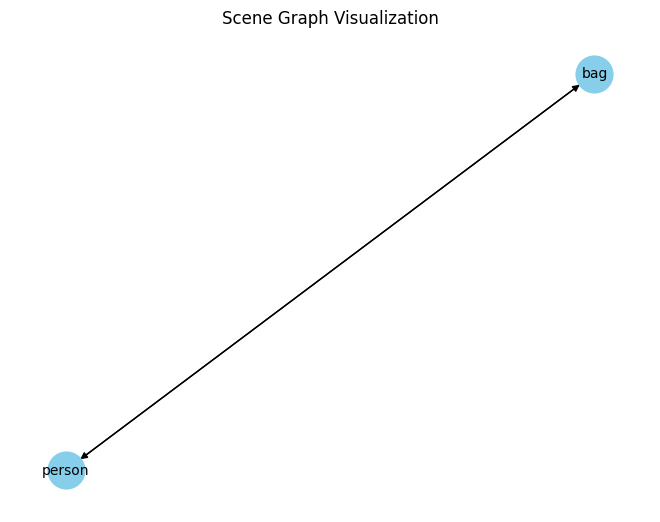

person -- lookingat --> bag
person -- haveitontheback --> bag
bag -- beneath --> person


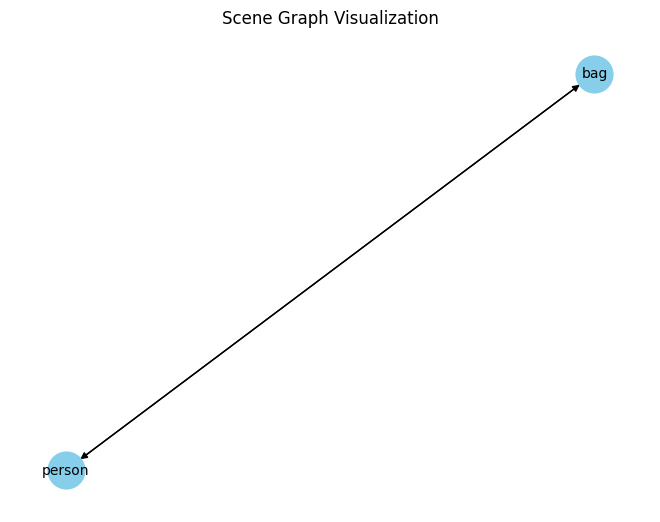

person -- haveitontheback --> bag
person -- lookingat --> bag


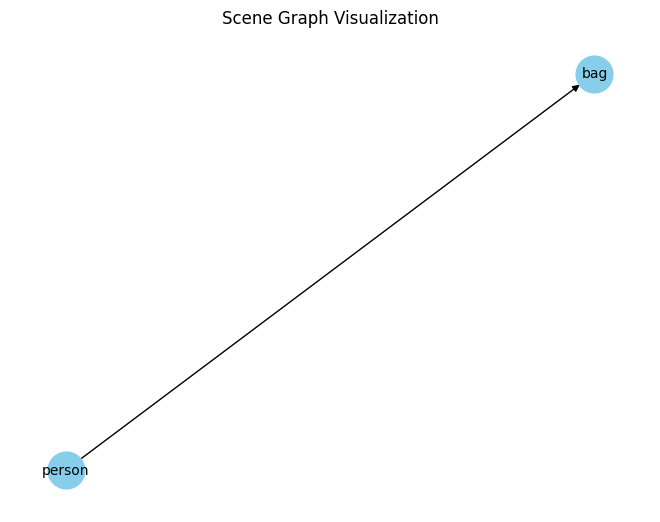

In [10]:
scene_graph_07BSH = plot_scene_graph(no_constraint_output_07BSH)

In [11]:
def scene_graph_to_text_prompt(scene_graph_data):
    object_descriptions = []
    relationship_descriptions = []
    
    # Describe each object
    for i, (k, v) in enumerate(scene_graph_data.items()):
        frame = k.split('/')[-1]
        rel_desc = []
        for sg in v:
            obj1_desc = f"There is a {sg['obj_1']}."
            obj2_desc = f"There is a {sg['obj_2']}."
            if obj1_desc not in object_descriptions:
                object_descriptions.append(obj1_desc)
            if obj2_desc not in object_descriptions:
                object_descriptions.append(obj2_desc)

            # Describe the relationship
            rel_desc.append(
                f"The {sg['obj_1']} is {sg['relationship']} {sg['obj_2']}."
            )
        relationship_descriptions.append(f'In frame {i}:\n- ' + '\n- '.join(rel_desc))

    # Combine descriptions
    prompt = "All objects in the scene:\n- " + "\n- ".join(object_descriptions) + "\n\n"
    prompt += "Relationships in the scene:\n- " + "\n- ".join(relationship_descriptions)
    # prompt = "In the scene:\n- " + "\n- ".join(object_descriptions + relationship_descriptions)
    
    return prompt

**015XE**

Description: A person is taking a picture of a light while sitting in a chair.

Captions: 
- A person holds a camera up to a light on the ceiling
- A person in a bedroom appears to use their phone to film or take a picture of the light fixture on the ceiling.
- A person is in a kitchen.  The person is taking a picture of the light in the kitchen.


In [12]:
# Convert the scene graph data to a text prompt
text_prompt = scene_graph_to_text_prompt(scene_graph_015XE)
print(text_prompt)

All objects in the scene:
- There is a person.
- There is a phonecamera.

Relationships in the scene:
- In frame 0:
- The person is haveitontheback phonecamera.
- The phonecamera is unsure person.
- The phonecamera is beneath person.
- In frame 1:
- The person is haveitontheback phonecamera.
- The phonecamera is unsure person.
- The phonecamera is beneath person.
- In frame 2:
- The person is haveitontheback phonecamera.
- The phonecamera is unsure person.


**07BSH**

Description: The person is vacuuming in the living room of their home.  They then realize they forgot to do their work of putting the groceries away.

Captions: 
- A person is vacuuming the living room floor then picks up some bags from the floor and leaves the room.
- A person vacuums the floor in the living room before bending over and picking up two bags and walking out.


In [13]:
# Convert the scene graph data to a text prompt
text_prompt = scene_graph_to_text_prompt(scene_graph_07QNG)
print(text_prompt)

All objects in the scene:
- There is a person.
- There is a book.
- There is a papernotebook.
- There is a bed.
- There is a cupglassbottle.
- There is a dish.

Relationships in the scene:
- In frame 0:
- The person is writingon book.
- The person is writingon papernotebook.
- The bed is above person.
- The person is lookingat bed.
- The person is otherrelationship bed.
- The book is beneath person.
- The papernotebook is beneath person.
- The bed is infrontof person.
- The person is standingon book.
- In frame 1:
- The person is writingon book.
- The person is writingon papernotebook.
- The bed is above person.
- The person is otherrelationship bed.
- The person is lookingat bed.
- The book is beneath person.
- The papernotebook is beneath person.
- The bed is infrontof person.
- The person is standingon book.
- In frame 2:
- The person is writingon book.
- The person is writingon papernotebook.
- The book is beneath person.
- The papernotebook is beneath person.
- The person is other

**07QNG**

Description: A person is in the bedroom doing homework and watching tv in the background. They stop to pour some water in a glass and take a drink, then they sit it down and get back to homework.

Captions: 
- The person in the video is watching a video and writing something on a piece of paper, then gets up and gets something to drink and sits back down.
- A person is sitting on a bed doing homework while they are watching tv the get up and pour a cup of juice then they sit back down on the bed and continue to do their homework.
- A person is sitting and working on their homework. The person is also watching television. The person stands up, pours water, and drinks it. The person goes back to sitting and working on their homework.


In [14]:
# Convert the scene graph data to a text prompt
text_prompt = scene_graph_to_text_prompt(scene_graph_07QNG)
print(text_prompt)

All objects in the scene:
- There is a person.
- There is a book.
- There is a papernotebook.
- There is a bed.
- There is a cupglassbottle.
- There is a dish.

Relationships in the scene:
- In frame 0:
- The person is writingon book.
- The person is writingon papernotebook.
- The bed is above person.
- The person is lookingat bed.
- The person is otherrelationship bed.
- The book is beneath person.
- The papernotebook is beneath person.
- The bed is infrontof person.
- The person is standingon book.
- In frame 1:
- The person is writingon book.
- The person is writingon papernotebook.
- The bed is above person.
- The person is otherrelationship bed.
- The person is lookingat bed.
- The book is beneath person.
- The papernotebook is beneath person.
- The bed is infrontof person.
- The person is standingon book.
- In frame 2:
- The person is writingon book.
- The person is writingon papernotebook.
- The book is beneath person.
- The papernotebook is beneath person.
- The person is other

# GPT-4 Experiment

Prompt: 
Your task is to perform video captioning given only the scene graph of the video.
You are given the scene graph for each frame of the video.
Many scene graphs might be same for consecutive frames. You should not same the same things over and over again. Your caption should be concise and short and describe only the most important things of the video. 

Example 1 (I provided the scene graph of video 07BSH and the corresponding captions)
Example 2 (I provided the scene graph of video 015XE and the corresponding captions)

Now it's your turn.

Input: (Here I provided the scene graph of video 07QNG)

Output: 

(Here is the LLM output)

A person engages in an extensive writing session, alternating between a book and a paper notebook while frequently looking at and interacting with a bed. Initially standing on the book for a better vantage point, the activity spans from intense writing sessions to moments of contemplation and interaction with the surroundings. Midway through the video, the scene shifts as the person begins to incorporate a cup, glass bottle, and dish into their routine, not only writing on these items but also eventually using them in a peculiar manner that involves having them on their back and even drinking from them. The video concludes with a return to writing on the book, maintaining a consistent pattern of work and interaction with the objects around.

# Claude 3 Sonnet Experiment

Prompt: 
Your task is to perform video captioning given only the scene graph of the video.
You are given the scene graph for each frame of the video.
Many scene graphs might be same for consecutive frames. You should not same the same things over and over again. Your caption should be concise and short and describe only the most important things of the video. 

Example 1 (I provided the scene graph of video 07BSH and the corresponding captions)
Example 2 (I provided the scene graph of video 015XE and the corresponding captions)

Now it's your turn.

Input: (Here I provided the scene graph of video 07QNG)

Output: 

(Here is the LLM output)

A person is seen writing in a notebook and looking at a bed, then gets a glass bottle and dish, drinks from them while writing, and goes back to writing in a book while standing.